# Practica Teoría de la Información

### Guillermo Hoyo Bravo y Adrián Rubio Pintado

## 1 Introducción

Para este problema vamos a tratar con series temporal donde presuponemos para el planteamiento del mismo, que los eventos que tienen la información son los spikes, es decir, los picos de las señales. Estas series temporales contienen información muestreada a partir de las neuronas VD y LP, en estados de control, inyección de Gaba y recuperación del sistema (C,G y R).

Haremos el desarrollo de todo el proceso descibiendo cada paso con el trozo C, junto con el código empleado, y luego repetiremos el estudio para los trozos G y R de datos proporcionados(correspondiente a estados de control, inyección de Gaba y recuperación del sistema cada trozo mencionado)


NOTA:Todo el código desarrollado en exclusiva para la práctica ha sido testeado con funciones no incluidas en la práctica por motivos de claridad y extensión de la misma

## Carga de Librerías 

In [148]:
import pandas as pd
#numpy 1.20 needed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from numpy.lib.stride_tricks import sliding_window_view
import hashlib

## Definición de Funciones Auxiliares 

In [3]:
def plot_original_signal_vs_ts_codification(original_data, codificated_signal, threshold, ylabel = 'Valores Temporales',
                                            title = 'Comparativa Señal Original vs. su Codificación Binaria',
                                            plot2_marker = ',',
                                           ):
    plt.plot(original_data, label= 'Señal Original', marker = plot2_marker)
    plt.plot(codificated_signal, label = 'Codificación Binaria', marker = plot2_marker)
    plt.axhline(y=threshold, color='green', linestyle='-', label = "Umbral")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel('Tiempo')
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.show()

In [194]:
def plot_comparativa(bin_len, array_con_w, ylabel = 'Información Mutua'
                     ,title = 'Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra'):
    '''
        Todos los bin_len deben de tener los mismos valores...
    '''
    for i in range(0,8):
        label = 'Tam. palabra ' + str(i+1)
        plt.plot(bin_len,array_con_w[i], label= label)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel('Tamaño ventana')
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.show()

## 2. Proceso de Estudio
## Carga de Datos

In [4]:
trozoC = pd.read_csv("DatosSinapsisArtificial/TrozoC.txt", names = ["LP", "VD"], 
                     skiprows = range(3),index_col = False,
                     delimiter = "\t", decimal = ",")

In [113]:
trozoG = pd.read_csv("DatosSinapsisArtificial/TrozoG.txt", names = ["LP", "VD","Spike"], 
                     skiprows = range(3),index_col = False,
                     delimiter = "\t", decimal = ",")

In [10]:
trozoR = pd.read_csv("DatosSinapsisArtificial/TrozoR.txt", names = ["LP", "VD"], 
                     skiprows = range(3),index_col = False,
                     delimiter = "\t", decimal = ",")

## Codificación de los Datos

Dado que tenemos series temporales discretizadas en los ficheros arriba cargados, debemos transformar la información para poder trabajar con ella. Queremos codificar eventos como los spikes de las series. Esta codificación que haremos será binaria, tal que la presencia de un spike se traducirá en el evento "1" y la ausencia de spike en el evento "0".

Para dicha transformación de la serie a señal binaria, debemos de establecer un umbral, a partir del cual un pico en debe de considerarse un evento 1 o no. Es decir, una altura mínima que deben de pasar los spikes para codificarlos como evento "1".
Esto lo hacemos de manera empírica, estableciendo un threshold o límite 

Inicialmente haremos un estudio del trozoC.txt explicando detalladamente el procedimiento empleado y los resultados obtenidos, y repetiremos finalmente el mismo estudio para el trozoG y trozoR de manera similar

## 2.1 Trozo C

### Determinando el umbral o threshold

Para determinar el threshold experimental abrimos el fichero trozoC.txt con el DataView.exe. Ahí vemos los dos channels, correspondientes a las series de las neuronas LP y VD.

Obsevamos primero la señal de la neurona LP para una muestra ampliada. Establecemos un threshold empírico de **0,31116** de acuerdo a la señal, donde la mayoría los spikes aparentemente más regulares o que tienen mayores máximos son alcanzados. Dejando así fuera lo que ante un primer vistazo pudiera parecer ruido(spikes mas bajos y con una forma aparentemente más irregular), esto lo podemos ver en la imagen de abajo, en el rectángulo rojo de la derecha del todo.

![Threshold para LP en Trozo C](img/imagen1.png) 
*Threshold para LP en Trozo C*


![Threshold para VD en Trozo C](img/imagen2.png)
*Threshold para VD en Trozo C*

Para la neurona VD obtenemos un threshold empírico de **0,146722**

In [11]:
threshold_lp_trozoC = 0.31116
threshold_vd_trozoC = 0.146722

### Detección de spikes y codificación binaria

###### Definición de una función para detectar picos

Primero definimos una función para detectar picos a partir que superen un límite o threshold dado.

In [117]:
def find_spikes(array, threshold):
    '''
        Iterates point by point and finds the peak point between the ones in the curves over the threshold
        
        Args:
            array: np array
            threshold: number
        Returns:
            Sequence of o and 1's where there is an 1 where a peak over the threshold is found
        
    
    '''
    codification = np.empty(array.size, dtype = int)
    spike_detected = False   #flag to control the peaks over the threshold, it can be  only one per curve over the limit
    
    for i in range(0,array.size) :
        xi = array[i]
        if(xi >= threshold):
            if(not spike_detected):#spike alredy found in this curve over the threshold
                if((i == array.size-1) or (xi > array[i+1]) ): 
                    #last element without having a spike yet or the element is bigger than the next point
                    codification[i] = 1 #spike found
                    spike_detected = True

            else:
                codification[i] = 0
        else:
            codification[i] = 0
            spike_detected = False
            
    return codification

Testeamos que el fucionamiento de la función sea correcto:

In [150]:
#TEST find_spikes
test_array =      np.array([1,2,3,6,7,15,10,      2,2,2,2,5,12,13,5])
umbral = 6
find_spikes_expected_output = np.array([0,0,0,0,0,1,0,        0,0,0,0,0,0,1,0],dtype = int)

find_spikes_test_output = find_spikes(test_array, umbral)

#print('Expected Fun output', find_spikes_expected_output)
#print('Actual Fun output', find_spikes_test_output)

assert np.array_equal(find_spikes_expected_output, find_spikes_test_output), 'Las salidas esperadas no coinciden en el test'
print('Test Passed OK')

Test Passed OK


#### Detectamos Picos

In [14]:
lp_trozoC = trozoC["LP"].to_numpy()
spikes_lp_trozoC = find_spikes(lp_trozoC, threshold_lp_trozoC)

vd_trozoC = trozoC["VD"].to_numpy()
spikes_vd_trozoC = find_spikes(vd_trozoC, threshold_vd_trozoC)

#### Pintamos una muestra de picos detectados

Tomamos una muestra de la señal de la neurona LP del archivo de control para ver como funciona nuestro detector de picos. Para ello, construimos una señal binaria codificada de la señal original compuesta por 1's en los puntos precisos donde hay picos y 0's en el resto de la cadena. Podemos verlo en la gráfica siguiente:

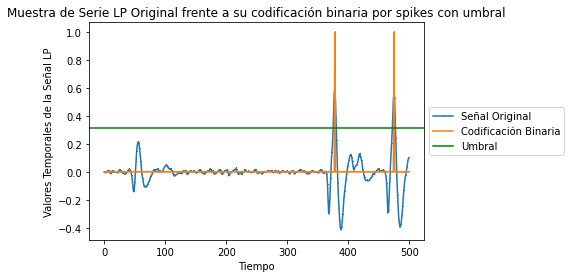

In [88]:
plot_original_signal_vs_ts_codification(lp_trozoC[2500:3000], spikes_lp_trozoC[2500:3000], threshold_lp_trozoC, 
                                        ylabel = 'Valores Temporales de la Señal LP',
                                        title = 'Muestra de Serie LP Original frente a su codificación binaria por spikes con umbral')


Ampliamos uno de los picos para obervarlo mejor:

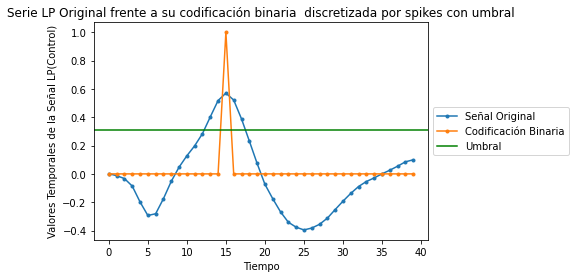

In [89]:
plot_original_signal_vs_ts_codification(lp_trozoC[2960:3000], spikes_lp_trozoC[2960:3000], threshold_lp_trozoC, 
                                        ylabel = 'Valores Temporales de la Señal LP(Control)',
                                        plot2_marker = '.',
                                        title = 'Serie LP Original frente a su codificación binaria  discretizada por spikes con umbral')


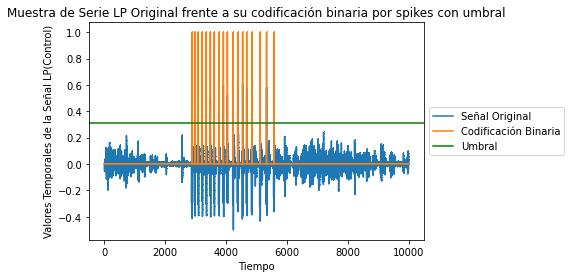

In [90]:
plot_original_signal_vs_ts_codification(lp_trozoC[0:10000], spikes_lp_trozoC[0:10000], threshold_lp_trozoC, 
                                        ylabel = 'Valores Temporales de la Señal LP(Control)',
                                        title = 'Muestra de Serie LP Original frente a su codificación binaria por spikes con umbral')




Repetimos el proceso para la señal de la neurona VD y pintamos una muesta para ver la detección de los spikes o picos:

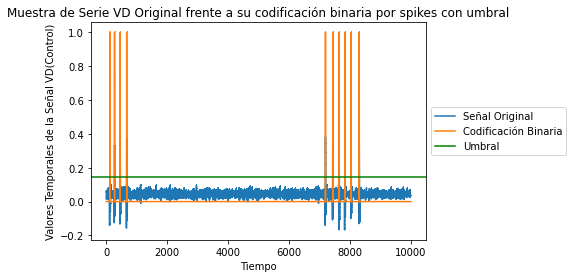

In [91]:
plot_original_signal_vs_ts_codification(vd_trozoC[0:10000], spikes_vd_trozoC[0:10000], threshold_vd_trozoC, 
                                        ylabel = 'Valores Temporales de la Señal VD(Control)',
                                        title = 'Muestra de Serie VD Original frente a su codificación binaria por spikes con umbral')


Ampliamos para verlo con mas detalle:
    

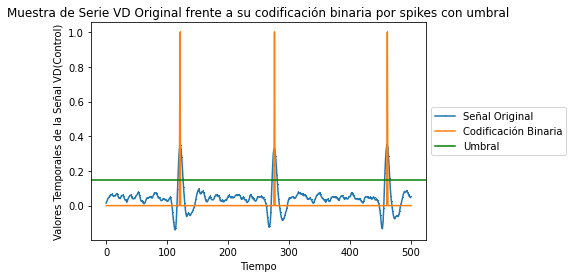

In [92]:
plot_original_signal_vs_ts_codification(vd_trozoC[0:500], spikes_vd_trozoC[0:500], threshold_vd_trozoC, 
                                        ylabel = 'Valores Temporales de la Señal VD(Control)',
                                        title = 'Muestra de Serie VD Original frente a su codificación binaria por spikes con umbral')


## CODIFICAMOS EN EVENTOS

Ahora que ya tenemos una función para detectar spikes, deseamos discretizar nuestras series temporales originales con ventanas de tamaño $\Delta t $. que contienen eventos Dentro de esas ventanas asignamos el valor 1 si dentro hay 1 o mas eventos o 0 si no hay ninguno.




In [15]:
def find_events(lp_spikes_positions, vd_spikes_positions, bin_len, count_events = False):
    ''' Finds the number of events in lp and vd signals given a bin_len and returns a binary list where there 
        is a 1 if the bin contais an spike, 0 if not.
        If count_events is True count the number of events
    
    
    '''

    lp_events = []
    vd_events = []
    
    lp_events_count = []
    vd_events_count = []
    for i in range(0,len(lp_spikes_positions),bin_len):
        lp_event = sum(lp_spikes_positions[i:i+bin_len])
        vd_event = sum(vd_spikes_positions[i:i+bin_len])
        if(count_events):
            lp_events_count.append(lp_event)
            vd_events_count.append(vd_event)
            
        if(lp_event > 0):#we have spikes in this bin
            lp_events.append(1)
        else:
            lp_events.append(0)
            
        if(vd_event > 0):#we have spikes in this bin
            vd_events.append(1)
        else:
            vd_events.append(0)
        
    return  lp_events ,vd_events , lp_events_count,  vd_events_count 

In [16]:
#Ejemplo de uso de find_events con un tamaño de ventana bin_len
bin_len = 1
evnts_lp_bin1_C, evnts_vd_bin1_C, _, _  =  find_events(spikes_lp_trozoC, spikes_vd_trozoC,bin_len = bin_len,count_events = False )

Definimos una fucnción para contar el número de colisiones, utilizando cualquiera de las dos últimas salidas de la función anterior si hemos marcado el argumento count_events = True.

In [17]:
def count_number_of_errors(events_count):
    ''' Devuelve el número de eventos malos, esto es, cuando en una ventana hay mas de dos spikes
        Cogiendo cualquiera de las 2 últimas salidas de la función anterior, vemos el numero de errores que hemos cometido
        para un determinado tamaño de ventana(bin size)
    
    '''
    
    return sum([1 if i>1 else 0  for i in events_count])

Utilizamos las funciones anteriores con nuestros datos. Probamos como el número de eventos fallidos aumenta a medida que aumentamos el tamaño de ventana. Consideramos un evento fallido cuando tenemos más de un spike en un bin o ventana de evento. Con tamaño de ventana 1 obetnemos como esperamos, 0 eventos erroneos, ya que para cada punto leído de la serie(discretizada), le asignamos una ventana, por lo que por definición es imposible que haya ningún error.

Definimos una función para ver la evolución de los errores segun el tamaño de la ventana elegido:

In [20]:
def grafica_errores_segun_binlen(spikes_lp, spikes_vd, init_bin_len = 1, stop_bin_len = 101, step_bin_len = 50, toleracia_errores = 0.05):
    '''Grafica la evolución de los eventos fallidos(más de un spike en un bin o ventana de evento) según incrementamos el tamaño
        de la ventana(bin)
    '''
    bin_len_list = []
    porcentaje_errs_en_lp = [] 
    porcentaje_errs_in_vd = []
    norm_errs_en_lp = [] 
    norm_errs_in_vd = []
    flag_lp=True
    flag_vd= True
    
    for bin_len in range(init_bin_len, stop_bin_len, step_bin_len):
        _, _, err_en_lp, err_in_vd  =  find_events(spikes_lp, spikes_vd,bin_len = bin_len,count_events = True )
        bin_len_list.append(bin_len)
        n_of_bins = int(len(spikes_lp)/bin_len)#numero de ventanas
        
        #Calculamos el total de errores
        total_err_lp = count_number_of_errors(err_en_lp)
        total_err_vd = count_number_of_errors(err_in_vd)
        
        #normalizamos los errores para que sean consecuentes al tam de ventana
        norm_err_lp= (total_err_lp * bin_len )/n_of_bins
        norm_err_vd= (total_err_vd * bin_len )/n_of_bins
        
        norm_errs_en_lp.append(norm_err_lp)
        norm_errs_in_vd.append(norm_err_vd)
        
        #Calculamos el porcentaje de errores
        porcentaje_errs_en_lp.append(total_err_lp/n_of_bins) 
        porcentaje_errs_in_vd.append( total_err_vd/n_of_bins)
        
        #print("Porcentaje de errores  ", porcentaje_errs_en_lp[-1] , "en LP, alcanzado con un tamaño de ventana:",bin_len )
        #print("Porcentaje de errores", porcentaje_errs_in_vd[-1] , "en VD, alcanzado con un tamaño de ventana:",bin_len )

        
        if(flag_lp and porcentaje_errs_en_lp[-1] >=toleracia_errores ):
            flag_lp = False
            print("Porcentaje de errores mayores al ", toleracia_errores , "en LP, alcanzado con un tamaño de ventana:",bin_len )
        if(flag_vd and porcentaje_errs_in_vd[-1] >=toleracia_errores ):
            flag_vd = False
            print("Porcentaje de errores mayores al ", toleracia_errores , "en VD, alcanzado con un tamaño de ventana:",bin_len )
            
        if(not flag_lp and not flag_vd):
            print('Error superior al 5% encontrado en ambas secuencias, finalizando estudio...')
            break
            
        
        
        
    #print(bin_len_list)
    #print(errs_en_lp) 
    #print(errs_in_vd,flush=True)
    
    # Numero Errores Normalizado segun el tamanio de la ventana
    plt.plot(bin_len_list,norm_errs_en_lp ,label= 'Señal LP', marker='o')
    plt.plot(bin_len_list, norm_errs_in_vd, label = 'Señal VD', marker='o')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Tamaño de la ventana o bin')
    plt.ylabel('Número de eventos erróneos')
    plt.title('Número de eventos erróneos(normalizados) segun el tamaño de la ventana')
    plt.show()
    
    #Porcentaje de errores segun el tamanio de la ventana
    plt.plot(bin_len_list,porcentaje_errs_en_lp ,label= 'Señal LP', marker='o')
    plt.plot(bin_len_list, porcentaje_errs_in_vd, label = 'Señal VD', marker='o')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Tamaño de la ventana o bin')
    plt.ylabel('Porcentaje eventos erróneos')
    plt.title('Porcentaje erróneos segun el tamaño de la ventana')
    plt.show()

Porcentaje de errores mayores al  0.05 en LP, alcanzado con un tamaño de ventana: 185
Porcentaje de errores mayores al  0.05 en VD, alcanzado con un tamaño de ventana: 208
Error superior al 5% encontrado en ambas secuencias, finalizando estudio...


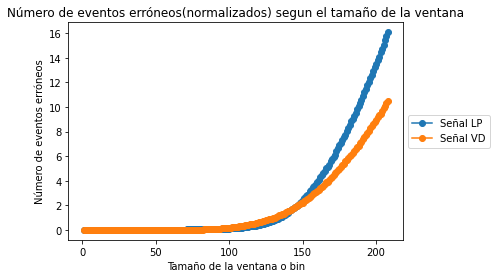

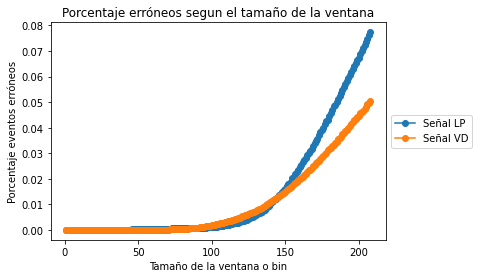

In [53]:
grafica_errores_segun_binlen(spikes_lp_trozoC, spikes_vd_trozoC, init_bin_len = 1, stop_bin_len = 500, step_bin_len = 1)


Hemos escogido un rango de estudio de ventana que iba desde 1 hasta 500 bits. Hemos programado el código de manera que finalice cuando en ambas series se haya alcanzado un porcentaje de eventos erróneos del 5%(un evento es erróneo cuando contien más de un spike). Hemos decidido parar cuando ambas alcanzaran un 5% de error y no cuando una de ellas lo hubiera hecho para comprobar si ambos valores se situaban cerca. Vemos que si, en el caso de la señal LP se alcanza en un tamaño de ventana de 185, bastante próximo al tamaño de 208 bits de ventana alcanzado por la serie VD del mismo trozo (C).

La codificación de eventos se hará por tanto con tamaños de ventana de 1 a 208.

## DEFINIMOS PALABRAS DE EVENTOS

Una vez tenemos una cadena codificada en bits de eventos discretizados, definimos palabras de eventos. Estas palabras estarán formadas por eventos, y tendrán una longitud desde 1 a 8 bits. 

Nos interesan las ventanas deslizantes de palabras para poder obtener la mayor combinación posible de eventos, ya que no sabemos nada acerca de cómo se estructura la información en las series y por tanto, en qué offset debemos empezar a estudiar la información para obtener un estudio  coherente. Con ello en vez de tomar bloques contiguos sobre la serie total de tamaño n bits(logitud de la palabra), tomamos desplazamientos de un bit por cada palabra, de modo que haya solapamientos.

In [21]:
def get_palabras_ventanas_deslizantes(eventos, bits_palabras):
    eventos_np = np.array(eventos,dtype=int)
    #window_shape = (0,bits_palabras)
    #palabras = view_as_windows(eventos_np, (bits_palabras,))
    palabras = sliding_window_view(eventos_np, bits_palabras)

    return palabras

### CALCULAMOS LAS PROBABILIDADES

Dado que necesitaremos saber la distribución de los datos para los cálculos del estudio, estimaremos las mismas a partir de la muestra, es decir, empíricamente a partir de los datos.

### Probabilidades Marginales

Definimos una función para cacular las probabilidades (marginales) de un conjunto de palabras:

In [25]:
def get_individual_probs(words):
    '''
        Args:
            words(np array): salida de la funcion get_palabras_ventanas_deslizantes
            
        Returns:
            probabilites(dict) {str(word): prob}
    '''
    #Calculate the freqs.
    unique_words , counts = np.unique(words, axis = 0, return_counts=True)
    #Now the probs.
    probabilities = {}
    
    #unique_words = [np.array_str(u) for u in unique_words ]
    #print('unique_words',unique_words)
    length = len(words)
    prob = lambda x : x/length
    counts = prob(counts)
    
    return {hashlib.sha1(k).hexdigest():v for k,v in zip(unique_words,counts)}

    #return {np.array_str(k):v for k,v in zip(unique_words,counts)}
    #return dict(zip(unique_words,counts))

    #return probs
    #for w, f in zip(unique_words, counts):
    #    probabilities[np.array_str(w)] = f/length
    #return probabilities

In [34]:
def get_probabilidad_marginal_palabra(probabilidades_marginales, word):
    
    if( type(word) == str):
        str_word = word
    else:
        str_word = hashlib.sha1(word).hexdigest()

    if(str_word) in probabilidades_marginales:
        return probabilidades_marginales[str_word]
    else:
        return 0

### Probabilidad Conjunta

Necesitamos también las probabilidades conjuntas, así que vamos a crear una función que nos permita calcularlas. Para ello, vamos a contar la frecuencia absoluta de la aparición conjunta de cada combinación de palabras y a partir de las frecuencias absolutas calculamos las probabilidades conjuntas como frecuencias relativas.

Teniendo dos cadenas de un total de N palabras, obtendremos una matriz de probabilidades conjuntas de tamaño NxN. Aunque por motivos prácticos no lo implementaremos como una matriz, si no en un diccionario, donde cada clave sea (palabra_i_serie1 ,palabra_j_serie2) y cada valor sea la frecuencia absoluta. A partir de esta frecuencia absoluta dividiremos entre N para obtener las probabilidades conjuntas. Las combinaciones de valores que no se den tendrán probabilidad 0. 
NOTA: Dado que la operación de convertir un array a cadena e indexar es muy costoso, hemos calculado el hash de cada array para acelerar los cálculos, por lo que ahora la clave es (hash(palabra_i_serie1) ,hash(palabra_j_serie2))

In [97]:
def get_probabilidades_conjuntas_dict(words_serie1, words_serie2):
    '''
        Calcula y devuelve las probabilidades conjuntas a partir de dos series de palabras
        words_serie1, words_serie2 deben de tener la misma longitud
        
        Args:
            words_serie1(np array): salida de la funcion get_palabras_ventanas_deslizantes para la serie 1(pe. lp)
            words_serie2(np array): salida de la funcion get_palabras_ventanas_deslizantes para la serie 2(pe. vd)
            
        Returns:
            probs(dict) {palabra_i_serie1" + "_" + "palabra_j_serie2: probabilidad_conjunta} probabilidades conjuntas
    '''

    freqs = {}

    #freqs = {}
    for w1,w2 in zip(words_serie1, words_serie2):
        #key = np.array_str(w1) + '_' + np.array_str(w2)
        w1hash = hashlib.sha1(w1).hexdigest()
        w2hash = hashlib.sha1(w2).hexdigest()

        key = (w1hash,w2hash)
        if(key in freqs):
            freqs[key] += 1 
        else:
            freqs[key] = 1
    
    #Dividimos entre N para obtener las probabilidades conjuntas a partir de las freqs. absolutas
    N = len(words_serie1)
    probs = {k: (v/N) for k, v in freqs.items()}
    #for k in freqs:
    #    freqs[k] = freqs[k] / N
        
    #return freqs
    return probs

In [41]:
def get_probabilidad_conjunta(probabilidades_conjuntas, word1, word2):
    
    '''
        Devuelve la probabilidad conjunta de 2 palabras pertenecientes a dos series distintas con probabilidad calculada 
        en probabilidades_conjuntas. Es importante respetar el mismo ordern para escoger las palabras word 1 y word 2
        que cuando se ha llamado a get_probabilidades_conjuntas_dict
    
    '''
    w1hash = hashlib.sha1(word1).hexdigest()
    w2hash = hashlib.sha1(word2).hexdigest()

    #key = np.array_str(word1) + '_' + np.array_str(word2)
    key = (w1hash,w2hash)
    
    if(key in probabilidades_conjuntas):
        return probabilidades_conjuntas[key]
    else:
        return 0


## INFORMACIÓN MUTUA

Con la información mutua calculamos la reducción de incertidumbre de una variable aleatoria al conocer del valor de otra variable aleatoria. Nos interesa utilizar dicha menidad, ya que tenemos dos señales de dos neuronas y consideramos una de ellas la variable estímulo y otra la variable respuesta. Por eso no interesa saber como la variable estímulo nos da una reducción de la incertidumbre sobre la variable respuesta, ya que sabemos que están correlacionadas entre sí.

Definimos por tanto la información mutua MI como:

$$MI(x,y)=\sum_{x,y} p(x,y)I(x;y)$$

donde I(x;y) se define con la información mutua entre sucesos tal que:

$$ I(xi,yi) = log2(\frac{p(xi | yi)}{p(xi)} ) $$

Desarrollando en la fórmula de la información mutua:

$$ MI(x,y) =\sum_{x,y} p(y)p(x|y)log2(\frac{p(x|y)}{p(x)})$$

Obtenemos finalmente que:

$$ MI(x,y) =\sum_{x,y} p(x,y)log2(\frac{p(x,y)}{p(x)p(y)})$$

(Como en nuestro caso ya disponemos de eventos discretizados, no necesitamos reemplazar los sumatorios por integrales)

Vemos que requerimos calcular las probabilidades individuales de cada variable así como de la 
probabilidad conjunta. Para estimar estas distribuciones de probabilidad, hacemos uso de los datos experimentales que tenemos, en este caso, las frecuencias de ocurrencia de cada palabra.

In [44]:
def calcula_im(probs_conjuntas, probs_marginales_x, probs_marginales_y):
    
    sumatorio = 0
    for k,v in probs_conjuntas.items():
        #print('k es', k)
        #x, y = k.split('_')
        x, y = k
        p_x = get_probabilidad_marginal_palabra(probs_marginales_x, x)
        p_y = get_probabilidad_marginal_palabra(probs_marginales_y, y)
        
        sumatorio = sumatorio + (v * np.log2( v/(p_x*p_y)) )
 
        
    return sumatorio

## TRANSFERENCIA DE INFORMACIÓN 
A partir de la Información Mutua, podemos normalizar y  definir la transferencia de informaciónde la siguiente manera:

$$ E_{XY} = \frac {MI_{XY}}{H(Y)}$$

donde H(Y) es la entropía de la variable Y definida como:
$$ H(Y) = -\sum_{i}p(y_{i})log2(p(y_{i})) $$
Definiendo X como variable respuesta e Y como variable estímulo.

Definimos una función para calcular la entropía que utilizaremos en el cálculo de la transferencia de información 

In [46]:
def calcula_entropia( probs_marginales):
    suma =  sum([p*np.log2(p) for p in probs_marginales.values()])
    return -suma

Testeamos la función anterior

In [47]:
probs_margianles_test = {'a': 0.2, 'b': 0.8}
expected_entropia = 0.7219280949
entropia_test = calcula_entropia(probs_margianles_test)
print('entropia_test: ', entropia_test)

assert np.isclose(entropia_test, expected_entropia) ,'La función de entropía no funciona correctamente'
print('Test OK')

entropia_test:  0.7219280948873623
Test OK


# Cáculo de la Información Mutua y la Transferencia de Información según el tamaño de la ventana

Definimos una función que automatiza todo el proceso y nos permite calcular la Información Mutua y la Transferencia de Información en función de un rango de tamaño de ventana dado. Lo hacemos simultáneamente para la secuencia de LP y VD



In [67]:
def calcula_im_por_rango_de_bins(spikes_lp_trozoC,spikes_vd_trozoC, word_bits, init_bin_len=1, stop_bin_len=500, step_bin_len = 1,verbose = False): 
    '''
        Para un tamño de palabra word_bits, calcula la IM en función del tamaño de ventana especificado en el rango.
        Utiliza ventanas deslizantes para obtener las palabras de información a partir de los eventos
        
    '''
    
    bin_lenghts = []
    im_values = []
    trans_info_lp_vd_values = []
    trans_info_vd_lp_values = []
    
    for bin_len in range( init_bin_len, stop_bin_len, step_bin_len):
        
        if(verbose):
            print('-->Tam. ventana: ', bin_len)
        evnts_lp_bin_i_C, evnts_vd_bin_i_C, _, _  =  find_events(spikes_lp_trozoC, spikes_vd_trozoC,bin_len = bin_len,count_events = False )
        if(verbose):
            print('\t\t Calculamos las palabras deslizantes')
        palabras_lp = get_palabras_ventanas_deslizantes(evnts_lp_bin_i_C, word_bits)
        palabras_vd = get_palabras_ventanas_deslizantes(evnts_vd_bin_i_C, word_bits)
        
        if(verbose):   
            print('\t\t Calculando probabilidades marginales')
        probs_lp = get_individual_probs(palabras_lp)
        probs_vd = get_individual_probs(palabras_vd)
        
        if(verbose):
            print('\t\tCalculando probabilidades conjuntas')
        probs_conjuntas_lp_vd = get_probabilidades_conjuntas_dict(palabras_lp, palabras_vd)

        if(verbose):    
            print('\t\tCalculando información mutua')
        im = calcula_im(probs_conjuntas_lp_vd, probs_lp, probs_vd)
        bin_lenghts.append(bin_len)
        im_values.append(im)
        
        if(verbose):
            print('\t\tCalculando Entropías')
        entropia_lp = calcula_entropia(probs_lp)
        entropia_vd = calcula_entropia(probs_vd)

        if(verbose):
            print('\t\tCalculando Transferencia de información')
        trans_info_lp_vd_values.append(im_values[-1]/entropia_lp)
        trans_info_vd_lp_values.append(im_values[-1]/entropia_vd)
    

    return bin_lenghts, im_values, trans_info_lp_vd_values, trans_info_vd_lp_values

In [55]:
c_w1__bin_len, c_w1__im_values, c_w1__trans_info_lp_vd_values, c_w1__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 1, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

-->Tam. ventana:  1
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  6
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  11
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  16
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  21
		 Calculamos las palabras deslizantes
		 Cal

		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  181
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  186
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  191
		 Calculamos las palabras deslizantes
		 Calculando probabilidades marginales
		Calculando probabilidades conjuntas
		Calculando información mutua
		Calculando Entropías
		Calculando Transferencia de información
-->Tam. ventana:  196
		 Calculamos las palabras deslizantes
		 Calculando probabi

In [58]:
c_w2__bin_len, c_w2__im_values, c_w2__trans_info_lp_vd_values, c_w2__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 2, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [61]:
c_w3__bin_len, c_w3__im_values, c_w3__trans_info_lp_vd_values, c_w3__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 3, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [62]:
c_w4__bin_len, c_w4__im_values, c_w4__trans_info_lp_vd_values, c_w4__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 4, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [63]:
c_w5__bin_len, c_w5__im_values, c_w5__trans_info_lp_vd_values, c_w5__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 5, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [64]:
c_w6__bin_len, c_w6__im_values, c_w6__trans_info_lp_vd_values, c_w6__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 6, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [65]:
c_w7__bin_len, c_w7__im_values, c_w7__trans_info_lp_vd_values, c_w7__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 7, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

In [59]:
c_w8__bin_len, c_w8__im_values, c_w8__trans_info_lp_vd_values, c_w8__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoC, spikes_vd_trozoC, word_bits = 8, init_bin_len=1, stop_bin_len=215, step_bin_len = 5)

		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabras deslizantes
		 Calculamos las palabra

Pintamos la comparativa de la información mutua en fución del tamaño de ventana para cada tamaño de palabra(de 1 a 8 bits)

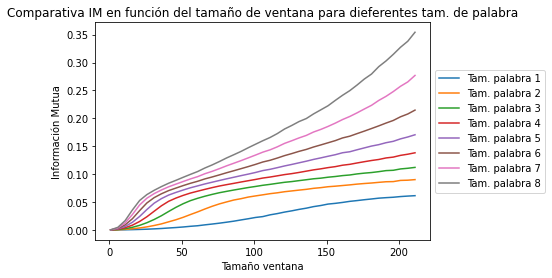

In [94]:
c_im__w_list = []
c_im__w_list.append(c_w1__im_values)
c_im__w_list.append(c_w2__im_values)
c_im__w_list.append(c_w3__im_values)
c_im__w_list.append(c_w4__im_values)
c_im__w_list.append(c_w5__im_values)
c_im__w_list.append(c_w6__im_values)
c_im__w_list.append(c_w7__im_values)
c_im__w_list.append(c_w8__im_values)

plot_comparativa(c_w1__bin_len, c_im__w_list, ylabel = 'Información Mutua',
                     title = 'Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')

Pintamos la comparativa de la transferencia de información de la neurona LP a la neurona VD  en fución del tamaño de ventana para cada tamaño de palabra(de 1 a 8 bits)

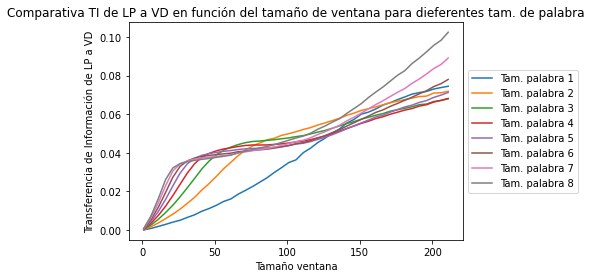

In [95]:
c_ti_lp_vd__w_list = []
c_ti_lp_vd__w_list.append(c_w1__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w2__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w3__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w4__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w5__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w6__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w7__trans_info_lp_vd_values)
c_ti_lp_vd__w_list.append(c_w8__trans_info_lp_vd_values)

plot_comparativa(c_w1__bin_len, c_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

Pintamos la comparativa de la transferencia de información de la neurona VD a la neurona LP  en fución del tamaño de ventana para cada tamaño de palabra(de 1 a 8 bits)

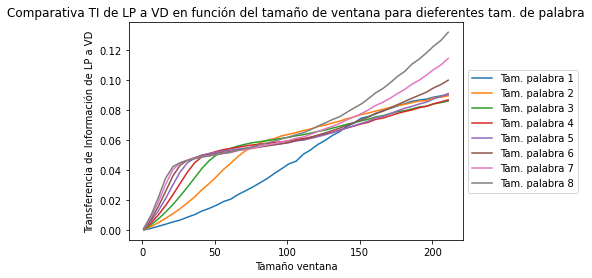

In [96]:
c_ti_vd_lp__w_list = []
c_ti_vd_lp__w_list.append(c_w1__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w2__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w3__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w4__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w5__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w6__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w7__trans_info_vd_lp_values)
c_ti_vd_lp__w_list.append(c_w8__trans_info_vd_lp_values)
plot_comparativa(c_w1__bin_len, c_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

# 2.2 TROZO G: ESTUDIO

### Determinando el umbral o threshold


Para determinar el threshold experimental abrimos el fichero trozoG.txt con el DataView.exe. Y determinamos el umbral del mismo modo que con el trozoC.txt


![Threshold para LP en Trozo G](img/lp_trozoG.png) 
*Threshold para LP en Trozo G*


![Threshold para VD en Trozo G](img/vd_trozoG.png)
*Threshold para VD en Trozo G*

Obteniendo los siguientes thresholds:

In [118]:
threshold_lp_trozoG = 0.362987
threshold_vd_trozoG = 0.259283

#### Detectamos Picos

In [120]:
lp_trozoG = trozoG["LP"].to_numpy()
spikes_lp_trozoG = find_spikes(lp_trozoG, threshold_lp_trozoG)

vd_trozoG = trozoG["VD"].to_numpy()
spikes_vd_trozoG = find_spikes(vd_trozoG, threshold_vd_trozoG)

####  Seleccionamos un tamaño de ventana máximo que tenga como mucho un 5% de eventos erróneos

Porcentaje de errores mayores al  0.05 en LP, alcanzado con un tamaño de ventana: 186
Porcentaje de errores mayores al  0.05 en VD, alcanzado con un tamaño de ventana: 251
Error superior al 5% encontrado en ambas secuencias, finalizando estudio...


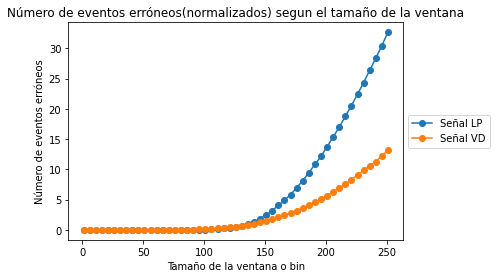

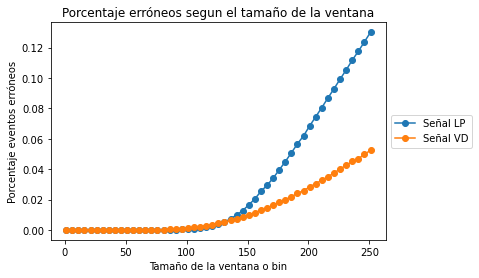

In [121]:
grafica_errores_segun_binlen(spikes_lp_trozoG, spikes_vd_trozoG, init_bin_len = 1, stop_bin_len = 500, step_bin_len = 5)


#### Calculamos la Información Mutua y las Transferencias de Información según el tam. de ventana para cada longitud de palabra

In [126]:
g_w1__bin_len, g_w1__im_values, g_w1__trans_info_lp_vd_values, g_w1__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 1, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [127]:
g_w2__bin_len, g_w2__im_values, g_w2__trans_info_lp_vd_values, g_w2__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 2, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [128]:
g_w3__bin_len, g_w3__im_values, g_w3__trans_info_lp_vd_values, g_w3__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 3, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [129]:
g_w4__bin_len, g_w4__im_values, g_w4__trans_info_lp_vd_values, g_w4__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 4, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [130]:
g_w5__bin_len, g_w5__im_values, g_w5__trans_info_lp_vd_values, g_w5__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 5, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [131]:
g_w6__bin_len, g_w6__im_values, g_w6__trans_info_lp_vd_values, g_w6__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 6, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [132]:
g_w7__bin_len, g_w7__im_values, g_w7__trans_info_lp_vd_values, g_w7__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 7, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

In [133]:
g_w8__bin_len, g_w8__im_values, g_w8__trans_info_lp_vd_values, g_w8__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoG, spikes_vd_trozoG, word_bits = 8, init_bin_len=1, stop_bin_len=255, step_bin_len = 5)

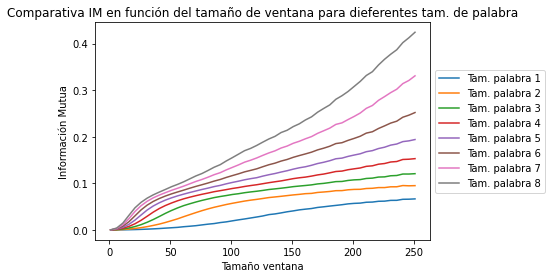

In [142]:
g_im__w_list = []
g_im__w_list.append(g_w1__im_values)
g_im__w_list.append(g_w2__im_values)
g_im__w_list.append(g_w3__im_values)
g_im__w_list.append(g_w4__im_values)
g_im__w_list.append(g_w5__im_values)
g_im__w_list.append(g_w6__im_values)
g_im__w_list.append(g_w7__im_values)
g_im__w_list.append(g_w8__im_values)

plot_comparativa(g_w1__bin_len, g_im__w_list, ylabel = 'Información Mutua',
                     title = 'Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')

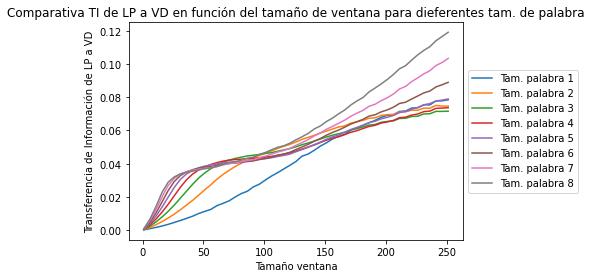

In [143]:
g_ti_lp_vd__w_list = []
g_ti_lp_vd__w_list.append(g_w1__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w2__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w3__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w4__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w5__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w6__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w7__trans_info_lp_vd_values)
g_ti_lp_vd__w_list.append(g_w8__trans_info_lp_vd_values)

plot_comparativa(g_w1__bin_len, g_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

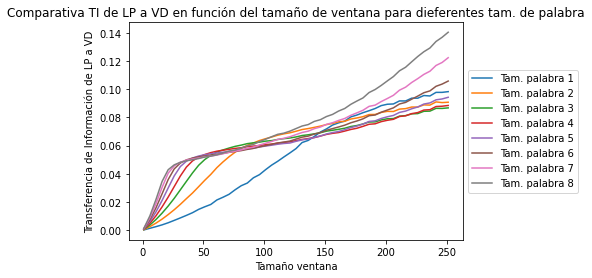

In [144]:
g_ti_vd_lp__w_list = []
g_ti_vd_lp__w_list.append(g_w1__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w2__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w3__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w4__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w5__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w6__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w7__trans_info_vd_lp_values)
g_ti_vd_lp__w_list.append(g_w8__trans_info_vd_lp_values)
plot_comparativa(g_w1__bin_len, g_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

# 2.3 TROZO R: ESTUDIO
### Determinando el umbral o threshold


Obtenemos los threshold empíricamente observando con el dataview.exe

![Threshold para LP en Trozo C](img/lp_trozoR.png) 
*Threshold para LP en Trozo R*


![Threshold para VD en Trozo R](img/vd_trozoR.png)
*Threshold para VD en Trozo R*

Obteniendo los siguientes thresholds:

In [123]:
threshold_lp_trozoR = 0.803896
threshold_vd_trozoR = 0.22854

#### Detectamos Picos

In [124]:
lp_trozoR = trozoR["LP"].to_numpy()
spikes_lp_trozoR = find_spikes(lp_trozoR, threshold_lp_trozoR)

vd_trozoR = trozoR["VD"].to_numpy()
spikes_vd_trozoR = find_spikes(vd_trozoR, threshold_vd_trozoR)

####  Seleccionamos un tamaño de ventana máximo que tenga como mucho un 5% de eventos erróneos


Porcentaje de errores mayores al  0.05 en LP, alcanzado con un tamaño de ventana: 191
Porcentaje de errores mayores al  0.05 en VD, alcanzado con un tamaño de ventana: 206
Error superior al 5% encontrado en ambas secuencias, finalizando estudio...


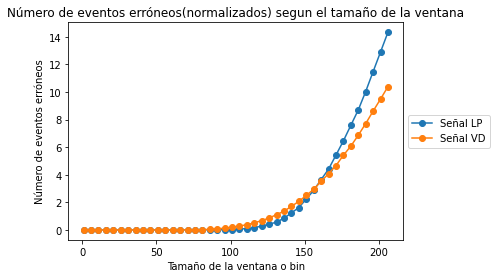

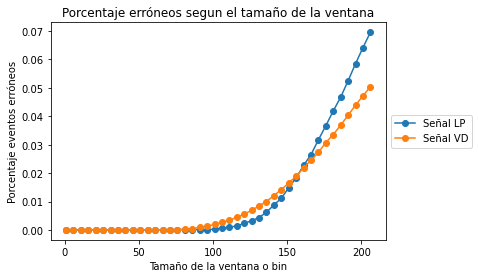

In [125]:
grafica_errores_segun_binlen(spikes_lp_trozoR, spikes_vd_trozoR, init_bin_len = 1, stop_bin_len = 500, step_bin_len = 5)


#### Calculamos la Información Mutua y las Transferencias de Información según el tam. de ventana para cada longitud de palabra


In [134]:
r_w1__bin_len, r_w1__im_values, r_w1__trans_info_lp_vd_values, r_w1__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 1, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [135]:
r_w2__bin_len, r_w2__im_values, r_w2__trans_info_lp_vd_values, r_w2__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 2, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)


In [136]:
r_w3__bin_len, r_w3__im_values, r_w3__trans_info_lp_vd_values, r_w3__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 3, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [137]:
r_w4__bin_len, r_w4__im_values, r_w4__trans_info_lp_vd_values, r_w4__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 4, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [138]:
r_w5__bin_len, r_w5__im_values, r_w5__trans_info_lp_vd_values, r_w5__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 5, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [139]:
r_w6__bin_len, r_w6__im_values, r_w6__trans_info_lp_vd_values, r_w6__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 6, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [140]:
r_w7__bin_len, r_w7__im_values, r_w7__trans_info_lp_vd_values, r_w7__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 7, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

In [141]:
r_w8__bin_len, r_w8__im_values, r_w8__trans_info_lp_vd_values, r_w8__trans_info_vd_lp_values = calcula_im_por_rango_de_bins(spikes_lp_trozoR, spikes_vd_trozoR, word_bits = 8, init_bin_len=1, stop_bin_len=210, step_bin_len = 5)

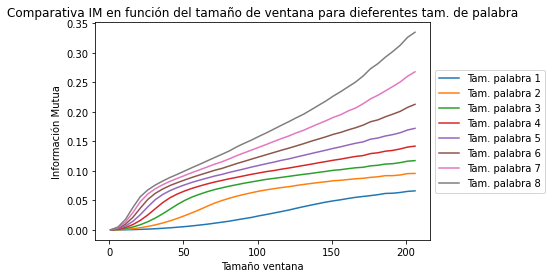

In [145]:
r_im__w_list = []
r_im__w_list.append(r_w1__im_values)
r_im__w_list.append(r_w2__im_values)
r_im__w_list.append(r_w3__im_values)
r_im__w_list.append(r_w4__im_values)
r_im__w_list.append(r_w5__im_values)
r_im__w_list.append(r_w6__im_values)
r_im__w_list.append(r_w7__im_values)
r_im__w_list.append(r_w8__im_values)

plot_comparativa(r_w1__bin_len, r_im__w_list, ylabel = 'Información Mutua',
                     title = 'Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')

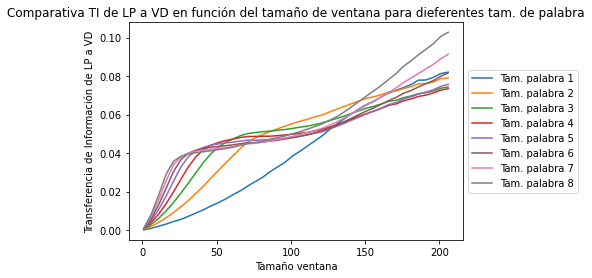

In [146]:
r_ti_lp_vd__w_list = []
r_ti_lp_vd__w_list.append(r_w1__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w2__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w3__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w4__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w5__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w6__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w7__trans_info_lp_vd_values)
r_ti_lp_vd__w_list.append(r_w8__trans_info_lp_vd_values)

plot_comparativa(r_w1__bin_len, r_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

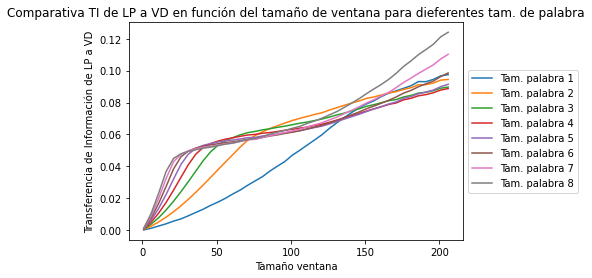

In [147]:
r_ti_vd_lp__w_list = []
r_ti_vd_lp__w_list.append(r_w1__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w2__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w3__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w4__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w5__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w6__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w7__trans_info_vd_lp_values)
r_ti_vd_lp__w_list.append(r_w8__trans_info_vd_lp_values)
plot_comparativa(r_w1__bin_len, r_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

## 3 ANÁLISIS DE LOS RESULTADOS

##### 3.1 Umbrales

Hemos obtenido los siguiente umbrales:


In [ ]:
threshold_lp_trozoC = 0.31116
threshold_vd_trozoC = 0.146722

threshold_lp_trozoG = 0.362987
threshold_vd_trozoG = 0.259283

threshold_lp_trozoR = 0.803896
threshold_vd_trozoR = 0.22854

Observamos como para la neurona LP se mantienen similares en ambos trozos excepto para el trozo R, recuperación, conde es mucho más alto, lo que no indica que los spikes en la recuperación tienen un mayor amplitud.
Para la neurona VD en cambio se mantienen más similares, siendo quizás el del trozo de control considerablemente más bajo, donde los spikes han tenido una apmplitud menor

#### 3.2 Informaciones mutuas

Comparamos la transferencia de información mutua para los 3 tozos:

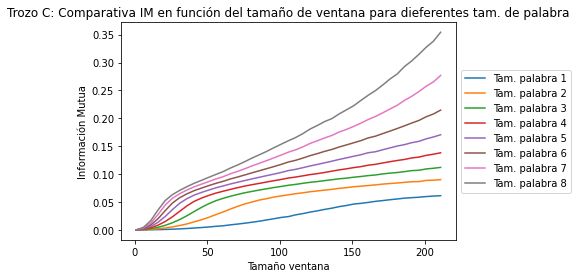

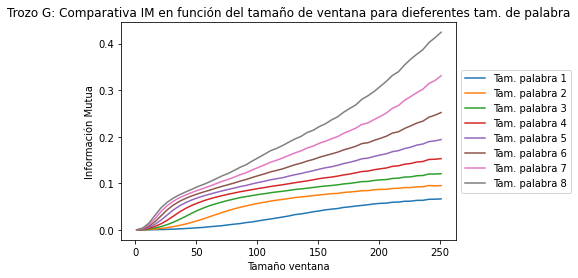

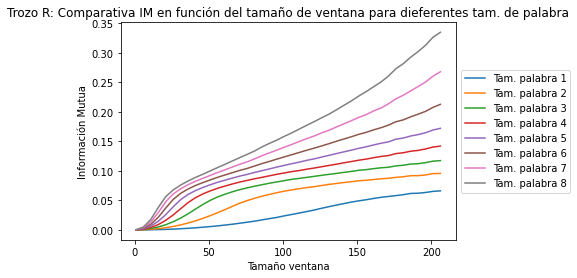

In [154]:

plot_comparativa(c_w1__bin_len, c_im__w_list, ylabel = 'Información Mutua',
                     title = 'Trozo C: Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')
plot_comparativa(g_w1__bin_len, g_im__w_list, ylabel = 'Información Mutua',
                     title = 'Trozo G: Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')
plot_comparativa(r_w1__bin_len, r_im__w_list, ylabel = 'Información Mutua',
                     title = 'Trozo R: Comparativa IM en función del tamaño de ventana para dieferentes tam. de palabra')

Observamos como en los 3 trozos la IM se comporta de manera prácticamente idéntica(si comparamos el mismo dominio que auque es muy cercano no es exactamente el mismo en los 3 estudios, ver mas detalles de porqué en la sección del estudio). Para cada tamaño de palabra se obtienen los mismos máximos y los mismos valores en general en el mismo rango de puntos.

La IM no es cero, ya que el conocimiento de una señal nos da información sobre la otra, es decir, no son totalmente independientes, como ya esperábamos ver.

Observamos que la IM aumenta según el tamaño de ventana. Dado que la IM mide al reducción de incertidumbre de una variable aleatoria cuando conocemos el valor de otra, nos interesa maximizar este valor. Sin embargo un tamaño de ventana cada veza más grande nos proporcionará información cada vez más errónea, y que por tanto no podemos tener en cuenta. Es por ello que el tamaño de ventana elegido ronda con máximo los 200 bits a la hora de codificar en eventos, ya que por conveniencia estadística, siempre el intervalo de confianza dado es del 95%.


Otra observación importante es el hecho de que un tamaño de ventana mayor produce un aumento más rápido de la IM. Dado que solo se pedía hasta 8 bits, es probable que tamaños superiores dieran crecimientos más rápidos. Sin embargo, al igual que con el tamaño de ventana valores muy grandes, por definicón, causarán errores cada vez más grandes.

Un detalle importane es que para tamaños de palabra bajos(1 y 2 bits, lineas azul y naranaja), vemos como el crecimiento es casi logarítmico, crece hasta parecer converger a un valor aparentemente máximo. En cambio para tamaños de ventana más grandes(7 y 8 bits, líneas rosa y gris), vemos como este comportamiento logarítmico se transforma más bien en uno casi lineal, el cual para valores grandes de tamaño de ventana, produce un crecimiento más rapido de la IM.

Podemos concluir que si queremos maximizar la IM en nuestras series debemos maximizar el tamaño de ventana y de palabra simultáneamente, hasta cierto punto, según el error que deseemos tolerar en nuestro estudio

#### 3.3  Transferencia de Información de LP a VD


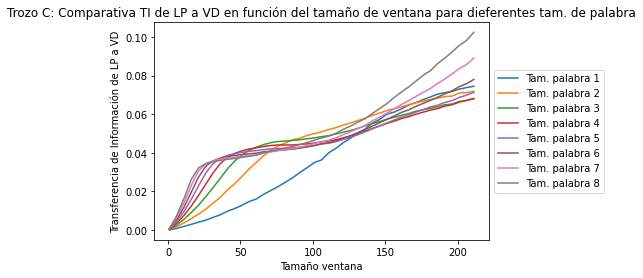

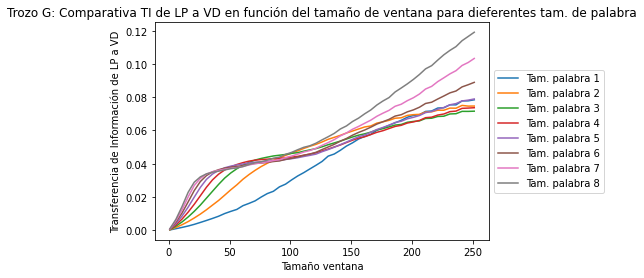

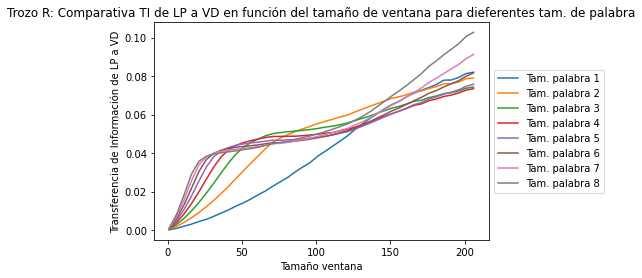

In [155]:
plot_comparativa(c_w1__bin_len, c_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo C: Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')
plot_comparativa(g_w1__bin_len, g_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo G: Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')
plot_comparativa(r_w1__bin_len, r_ti_lp_vd__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo R: Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

Como en el caso anterior, los valores para cada trozo C,G y R presentan a nivel práctico el mismo comportamiento. Dada la relación de la IM con la transferencia de información, a medida que aumentamos el tamaño de ventana, aumentamos la transferencia de información

Observamos como cambia ahora el comportamiento a medida que aumentamos el tamaño de palabra, para tamaños de palabra la transferencia de informacion de LP a VD tiene un comportamiento lineal, para valores más grandes, tiene un comportamiento logarítmico hasta tamaño de ventana 100, a partir del cual se vuelve más lineal.

Vamos a ver la transferencia de información de VD a LP ahora para determinar cual es realmente la variable estímulo y cual la respuesta, ya que la transferencia de información no es un operador simétrico.

#### 3.4  Transferencia de Información de VD a LP

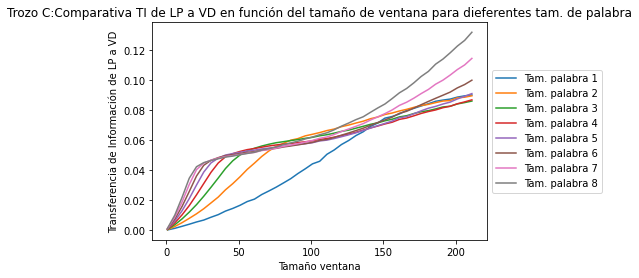

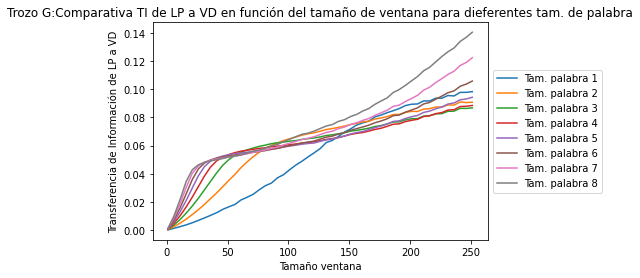

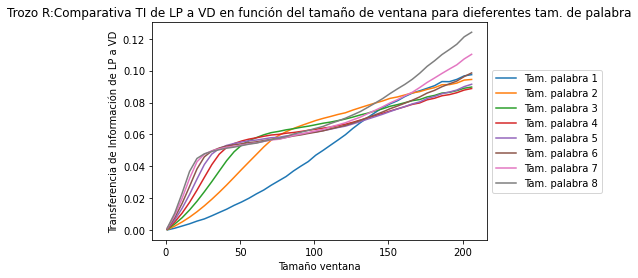

In [156]:
plot_comparativa(c_w1__bin_len, c_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo C:Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

plot_comparativa(g_w1__bin_len, g_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo G:Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

plot_comparativa(r_w1__bin_len, r_ti_vd_lp__w_list, ylabel = 'Transferencia de Información de LP a VD',
                     title = 'Trozo R:Comparativa TI de LP a VD en función del tamaño de ventana para dieferentes tam. de palabra')

Como en los dos casos anteriores los valores para cada trozo C,G y R presentan a nivel práctico el mismo comportamiento. Tenemos un comportamiento en el crecimiento igual al de la transferencia de información de LP a VD también.

Sin embargo, vemos como para una combinación tamaño ventana-tamaño palabra, los máximos alcanzados son ahora más altos.
Por ejemplo, en el trozo G, para un tamaño de palabra 8 bits y de ventana 250, en la trasferencia LP-VD teníamos un maximo de 0.10, en la transferencia VD-LP de 0.12
Esto es debido a que la neurona VD funciona como trigger para LP. Hay transferencia de información en ese sentido, con  la inyección de gaba al 4º spike de VD en el trozo G lo vemos de manera más clara, de ahí el ejemplo descrito en el párrafo superior.

# 4 SAX (Symbolic Aggregate approXimation)

SAX es un método de discretización de señales mediante una secuencia de letras. Lo utilizaremos como método alternativo a la codificación de nuestras señales para el cálculo de la IM. Haremos uso por eso de la librería **SAXpy**. 

Especificando un tamaño máximo de alfabeto, SAX codifica nuestra serie en un conjunto de letras. Sin embargo, dada la alta dimensionalidad de nuestras series discretizadas necesitamos reducir la dimensionalidad de las series para poder tener algo considerablemente computable para el estudio. 

Es por ello que vamos a utiliar una reducción de la dimensionalidad combinando SAX con PAA (Piecewise Aggregate Approximation).PAA reduce el número de puntos usando una ventana deslizante y cogiendo la media del valor de dicha ventana. Con esto pasamos de tener unsa serie de N puntos a una de M punto con M<<N. Cabe decir que antes de utilizar PAA normalizamos las series para obtener una mayor eficiencia del algoritmo.

Sobre nuestras series discretizadas en carácteres mediante SAX + PAA, utilizando diversos tamaños de palabra calcularemos la IM.

Por similitud en los cálculos anteriores de resultados haremos este estudio sobre el trozo C.

In [175]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize


Definimos las funciones adecuadas para calcular las probabilidades y luego la IM para este tipo de codificación:

In [169]:
def sax_calc_marginal_probs(string):
    ''' return dict with k:v being k the letter and v the prob'''
    counter = Counter(string)
    counter_probs = {k:v/len(string) for k,v in counter.items()}
    return counter_probs

In [171]:
def sax_get_marginal_prob(marginal_probs,char):
    return marginal_probs[char]

In [180]:
def sax_calc_joint_probs(string_1, string_2):
    
    freqs = {}

    for w1,w2 in zip(string_1, string_2):
      
        key = (w1,w2)
        if(key in freqs):
            freqs[key] += 1 
        else:
            freqs[key] = 1
    
    #Dividimos entre N para obtener las probabilidades conjuntas a partir de las freqs. absolutas
    N = len(string_1)
    probs = {k: (v/N) for k, v in freqs.items()}

    return probs

In [173]:
def sax_get_joint_prob(joint_probs, char_1,char_2):
    return joint_probs[(char_1,char_2)]

In [174]:
def sax_calcula_im(probs_conjuntas, probs_marginales_x, probs_marginales_y):
    
    sumatorio = 0
    for k,v in probs_conjuntas.items():
        x, y = k
        p_x = sax_get_marginal_prob(probs_marginales_x, x)
        p_y = sax_get_marginal_prob(probs_marginales_y, y)
        
        sumatorio = sumatorio + (v * np.log2( v/(p_x*p_y)) )
 
        
    return sumatorio

Testeamos el correcto funcionamiento de la función de cálculo de la IM:

In [187]:
im = sax_calcula_im(sax_calc_joint_probs(s1,s2), sax_calc_marginal_probs(s1), sax_calc_marginal_probs(s2) )  
print('im de words1 y words2:', im)

sumando_1 =  0.25 * np.log2( 0.25/(3/4 * 1/4)  )
sumando_2 = 0.5 * np.log2( 0.5/(3/4 * 3/4)  )
sumando_3 = 0.25 * np.log2( 0.25/(1/4 * 3/4)  )

expected_im = sumando_1 + sumando_2 + sumando_3
print('expected_im', expected_im)

assert im ==expected_im, 'Error en el test de la función calcula_im'


im de words1 y words2: 0.12255624891826566
expected_im 0.12255624891826566


In [205]:
def sax_get_palabras_ventanas_deslizantes(l, n):
  

    return [l[i:i + n] for i in range(0, len(l), n)]

#strin = 'abcdefgh'
#sax_get_palabras_ventanas_deslizantes(strin,3)

['abc', 'def', 'gh']

Vemos como obtenemos el valor deseado.Ahora por ello vamos a hacer una función que nos automatice el proceso al igual que con la codificación en spikes. 

Para ello vamos a calcular, para un valor de prefijado PAA (en nuestra implementación el tamaño final de la serie)y uno de alfabeto SAX(número distinto de carácteres) calcular la IM variando el tamaño de palabra empleado(combinación de varios caracteres.)



Vamos a ver como influyen el tamaño PAA y el del alfabeto SAX en nuestro estudio.
A tamaño de PAA más grandes, conseguiremos una series más pequeñas, al igual que nos ocurria con los tamaños de ventana.Con tamaño muy pequeños, apenas conseguiremos una reducción de la dimensionalidad.


Al elegir tamaño de alfabetos cada vez más pequeños, obtenedremos cadenas más monótonos hasta tal punto de no tener información suficiente para estudiarla. Con tamaños de alfabeto muy grandes, tendremos mayor variedad de palabras, por lo que será muy probable que muchas nunca se repitan y tampoco podramos obtener mucha información de ellas.

Es por ello que empíricamente le daremos valores a estos dos hyperparámetros para ver como nos afectan:

In [298]:
def sax_calcula_im_por_tam_palabra(array_lp,array_vd, tam_ini=1,tam_final=8, tam_step =1,num_letters = 10,paa_size = 3):

    ''' 
        Iterando sobre el tamaño de una PALABRA(conjunto de caracteres), calcula la IM de las 2 series para un tamaño de 
        alfabeto SAX dado y n tamaño PAA  dado que será la longtiud de la serie a analizar.
            tam: word size 
    
    '''
    tam_sizes = []
    ims = []
    lp_znorm = znorm(array_lp)
    vd_znorm = znorm(array_vd)

    for tam in range(tam_ini,tam_final, tam_step ):
        
        lp_paa = paa(lp_znorm, paa_size)
        lp_string = ts_to_string(lp_paa, cuts_for_asize(num_letters))
        lp_words = sax_get_palabras_ventanas_deslizantes(lp_string,tam)
        
        vd_paa = paa(vd_znorm, paa_size)
        vd_string = ts_to_string(vd_paa, cuts_for_asize(num_letters))
        vd_words = sax_get_palabras_ventanas_deslizantes(vd_string,tam)


        probs_conjuntas = sax_calc_joint_probs(lp_words,vd_words)
        probs_lp=sax_calc_marginal_probs(lp_words)
        probs_vd =sax_calc_marginal_probs(vd_words)
        #print('check point 4', probs_lp)

        im = sax_calcula_im(probs_conjuntas,probs_lp ,  probs_vd) 
        #print('check point 5')

        tam_sizes.append(tam)
        ims.append(im)
        
    return tam_sizes,ims 

Por rapidez en las evaluaciones utilizaremos solo un rango de los datos del trozo C

In [302]:
leen = len(lp_trozoC[0:100000])
tam_sizes,ims  = sax_calcula_im_por_tam_palabra(lp_trozoC[0:100000],vd_trozoC[0:100000], tam_ini=1,tam_final=4, tam_step =1,
                                                 num_letters = 5, paa_size = int(0.5*leen))

No handles with labels found to put in legend.


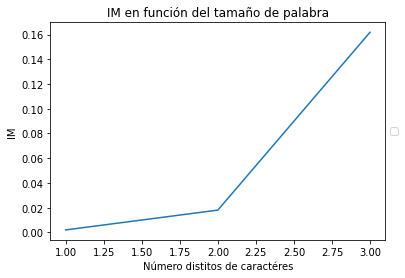

In [304]:

plt.plot(tam_sizes,ims, label= '')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Número distitos de caractéres')
plt.ylabel('IM')
plt.title('IM en función del tamaño de palabra')
    
plt.show()

Observamos como para datos modestos obtenemos que hay información mutua entre las series(con valores similares al estudio con spikes)

No handles with labels found to put in legend.


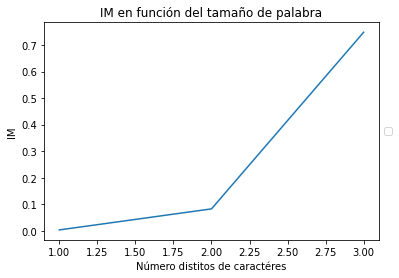

In [307]:
leen = len(lp_trozoC[0:100000])
tam_sizes,ims  = sax_calcula_im_por_tam_palabra(lp_trozoC[0:100000],vd_trozoC[0:100000], tam_ini=1,tam_final=4, tam_step =1,
                                                 num_letters = 8, paa_size = int(0.5*leen))


plt.plot(tam_sizes,ims, label= '')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Número distitos de caractéres')
plt.ylabel('IM')
plt.title('IM en función del tamaño de palabra')
    
plt.show()

Observamos como en este caso, utilizando un número de letras mayor la IM se dispara a casi un valor de 1, por lo que es probable que para estos valores de los hiperparámetros nos hayamos ajustado demasiado a los datos, sobre-simplificandolos.Es por ello que la elección anterior nos ofrecía una información sobre la correlación de las series con mayor granulidad.

# 5 Conclusiones

* Hemos observado como aumentar el tamaño de ventana aumenta la información mutua entre dos variables, lo cual es desable, pero no podemos abusar de ello, ya que aumentar el tamaño de ventana también aumenta el error producido.

* Hemos visto como tamaños de ventana mayores producen un crecimiento más rápido de la información mutua. Utilizando ventanas deslizantes conseguimos un estudio más completo

* Por ello si queremos maximizar la IM en nuestras series debemos maximizar el tamaño de ventana y de palabra simultáneamente, hasta cierto punto, según el error que deseemos tolerar en nuestro estudio.

* Hemos visto como hay una tranferencia de información de la neurona VD a LP, gracias a que la transferencia de información no es un operador simétrico y obtenemos valores más altos que con la transferencia de información de LP a VD.

* Todas las gráficas tienen comportamientos  con valores muy cercanos con los distintos trozos de Control,Gabba y Reposo. Siendo tal vez la más dispar el trozo Gabba, ya que Control y Reposo son las fases antes y despues de Gabba durante el experimento.

* También hemos estudiado la codificación SAX para eventos, en combinación con el algoritmo reductor de la dimensión PAA viendo como afectan sus hiperparámetros al cálculo objetvo_la IM entre las 2 series.